*Variational Auto Encoder*

References are stated in READ.ME

In [ ]:
#--------------------------------------------------------
# Imports
#--------------------------------------------------------
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
from keras.models import Sequential, Model
from keras.layers import Input,LSTM, Dense, Lambda

import numpy as numpy

from keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.losses import mse, binary_crossentropy
from keras import backend as keras

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
#-------------------------------------------------------
# Loading Data
#-------------------------------------------------------

mnist = input_data.read_data_sets("mnist", one_hot=True)

x_train = mnist.train.images
y_train = mnist.train.labels

x_test = mnist.test.images
y_test = mnist.test.labels

print("Shape of data")
print("X train : " , x_train.shape)
print("Y train : " , y_train.shape)
print("X test : " , x_test.shape)
print("Y test : " , y_test.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Shape of data
X train :  (55000, 784)
Y train :  (55000, 10)
X test :  (10000, 784)
Y test :  (10000, 10)


In [ ]:
#-------------------------------------------------------
# Define parameters
#-------------------------------------------------------

time_steps = 28           # Timesteps value in timeseries data
n_inputs  = 28            # rows of 28 pixels (an mnist img is 28x28)
n_classes = 10            # mnist classes/labels (0-9)

batch_size  = 256         # Size of each batch
n_epochs  = 30            # Size of epoch
n_hiddenunits = 256       # Hidden units in LSTM layer
latent_dim = 16           # Dimension in the latens space which is the input of decoder layer
hidden_dim_decoder = 256  # Dimension in hidden layer of the decoder model
validation_split = 0.2    # Ratio that splits data from training set for validation through epocs



In [ ]:
#-------------------------------------------------------
# Create model
#-------------------------------------------------------

x_train = mnist.train.images
y_train = mnist.train.labels

print("Shape of train data : ", x_train.shape)
print("Reshaping train data ...")

x_train = x_train.reshape(-1,time_steps, n_inputs)
print("New Shape of train data : ", x_train.shape)

def sampling(args):
    mean, log_var = args
    batch = keras.shape(mean)[0]
    dimension = keras.int_shape(log_var)[1]

    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = keras.random_normal(shape=(batch, dimension))
    return mean + keras.exp(0.5 * log_var) * epsilon


# Creating LSTM Encoder

model = Sequential()

input_layer = Input(shape=(time_steps, n_inputs) , name='Input_Layer')

lstm_layer = LSTM( units=n_hiddenunits, 
                   input_shape=(time_steps, n_inputs), 
                   activation='tanh', 
                   recurrent_activation='sigmoid',
                   name='LSTM_Layer')(input_layer)

mean_v = Dense(latent_dim, name='Mean')(lstm_layer)    
variance_v = Dense(latent_dim, name='Variance')(lstm_layer)
sampling_layer = Lambda(sampling, output_shape=(latent_dim,), name='Lambda')([mean_v, variance_v])
encoder = Model(input_layer, [mean_v, variance_v, sampling_layer], name='Encoder')

print("Detailed Model Information")

encoder.summary()

# Creating  Fully Connected Decoder

latent_input_layer = Input(shape=(latent_dim,), name='Latent_Input_Layer')
decoder_hidden_layer = Dense(hidden_dim_decoder, activation='relu', name="Decoder_Hidden_Layer")(latent_input_layer)
outputs = Dense(n_inputs*time_steps, activation='sigmoid', name="Output_Layer")(decoder_hidden_layer)

decoder = Model(latent_input_layer, outputs, name='Decoder')
decoder.summary()

# Creating VAE

sample = encoder(input_layer)[2] #Sample would be the sampling layer in encoder model.
outputs = decoder(sample)
vae_model = Model(input_layer, outputs, name='Variational_Auto_Encoder')

vae_model.summary()



Shape of train data :  (55000, 784)
Reshaping train data ...
New Shape of train data :  (55000, 28, 28)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Detailed Model Information
Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        (None, 28, 28)       0                                            
__________________________________________________________________________________________________
LSTM_Layer (LSTM)               (None, 256)          291840      Input_Layer[0][0]                
__________________________________________________________________________________________________
Mean (Dense)                    (None, 16)           4112        LSTM_Layer[0][0]                 
______________________________________________________________________________

In [ ]:
# Loss function

def loss(true, pred):

  reconstruction_loss = binary_crossentropy(keras.flatten(true), keras.flatten(pred)) * n_inputs * time_steps

  kl_loss = 1 + variance_v - keras.square(mean_v) - keras.exp(variance_v)
  kl_loss = keras.sum(kl_loss, axis=-1)
  kl_loss *= -0.5

  return keras.mean(reconstruction_loss + kl_loss)


In [ ]:
# Compile VAE Model
vae_model.compile(optimizer='adam', loss=loss)

# Train VAE Model
vae_model.fit(x_train, x_train, epochs = n_epochs, batch_size = batch_size, validation_split = validation_split)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 44000 samples, validate on 11000 samples
Epoch 1/30
44000/44000 [==============================] - 11s 249us/step - loss: 232.5216 - val_loss: 199.2552
Epoch 2/30
44000/44000 [==============================] - 10s 228us/step - loss: 186.6604 - val_loss: 170.6906
Epoch 3/30
44000/44000 [==============================] - 10s 230us/step - loss: 158.3110 - val_loss: 149.5503
Epoch 4/30
44000/44000 [==============================] - 10s 231us/step - loss: 143.4585 - val_loss: 138.8732
Epoch 5/30
44000/44000 [==============================] - 10s 230us/step - loss: 134.6763 - val_loss: 131.7462
Epoch 6/30
44000/44000 [==============================] - 10s 227us/step - loss: 128.1073 - val_loss: 126.1202
Epoch 7/30
44000/44000 [==============================] - 10s 231us/step - loss: 123.6981 - val_loss: 122.6920
Epoch 8/30
44000/44000 [==============================] - 10s 227us/step - los

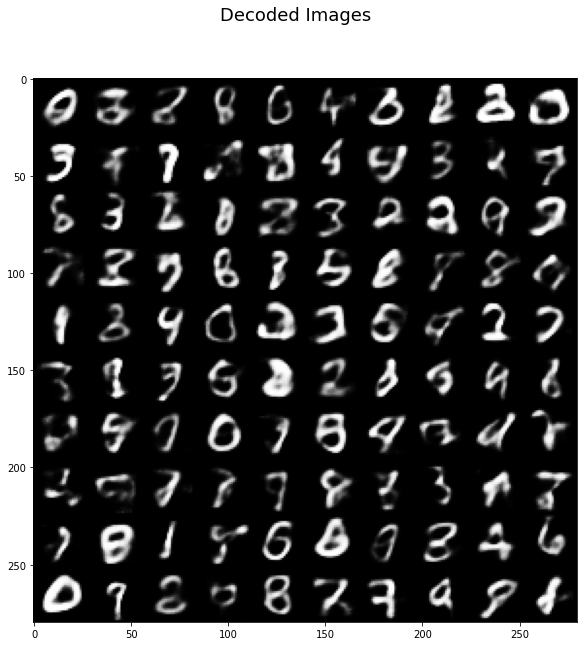

In [ ]:
# Plotting Results

def plot_decoded_images(n_images): 
    sample = numpy.random.normal(size=[n_images*n_images, latent_dim])
    decoded_data_point = decoder.predict(sample)

    n = numpy.sqrt(100).astype(numpy.int32)
    image_generated = numpy.empty((28*n, 28*n))
    for i in range(n):
        for j in range(n):
            image_generated[i*28:(i+1)*28, j*28:(j+1)*28] = decoded_data_point[i*n+j, :].reshape(28, 28)
    plt.figure(figsize=(10, 10))
    plt.suptitle('Decoded Images', fontsize=18)
    plt.imshow(image_generated, cmap='gray')

plot_decoded_images(10)